In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.stats import poisson
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

Problem 1

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

----------------------

PROBLEM 1

-------------------------

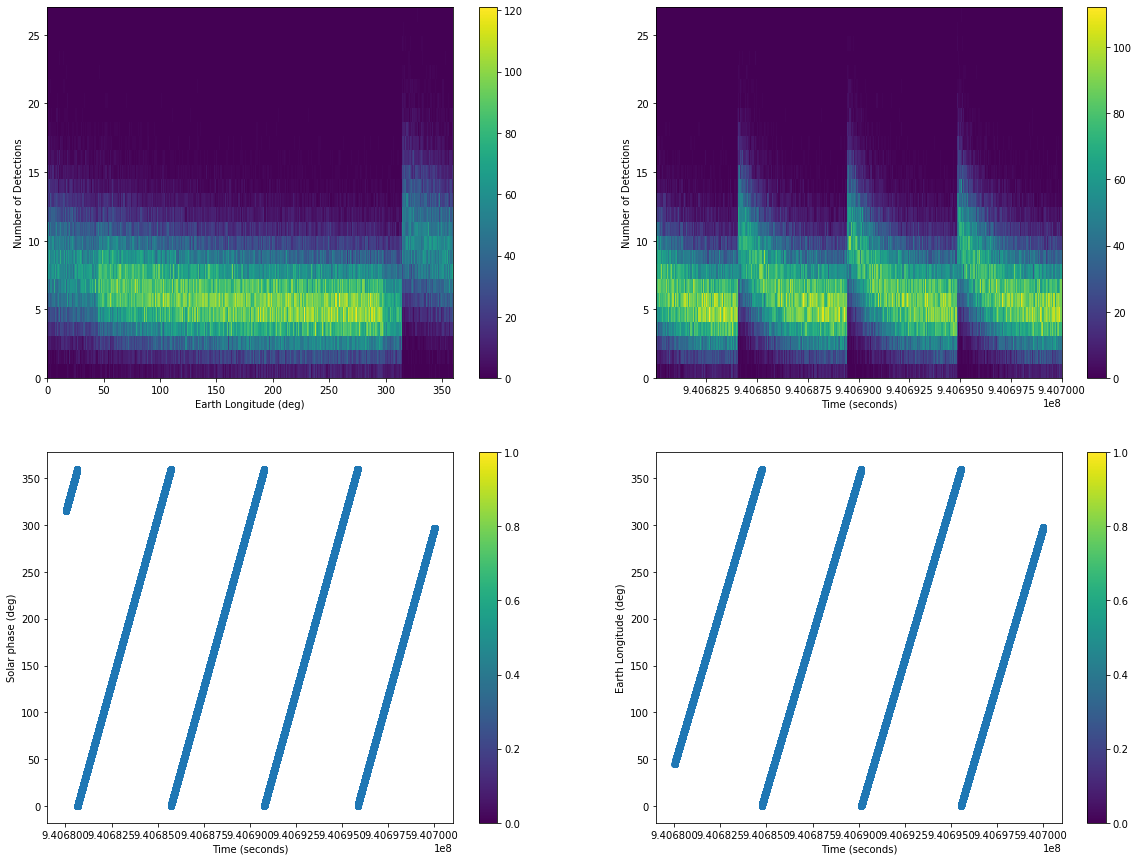

In [7]:
plt.subplot(2, 2, 1)
plt.hist2d(data[2,0:200000:1],data[3,0:200000:1], [360, 26])
plt.title('')
plt.xlabel('Earth Longitude (deg)')
plt.ylabel('Number of Detections')
plt.colorbar()
#plt.show()
plt.subplot(2, 2, 2)
plt.hist2d(data[0,0:200000:1],data[3,0:200000:1], [360, 26])
plt.title('')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Detections')
plt.colorbar()
#plt.show()
plt.subplot(2, 2, 3)
plt.scatter(data[0,0:200000:4],data[1,0:200000:4])
plt.title('')
plt.xlabel('Time (seconds)')
plt.ylabel('Solar phase (deg)')
plt.colorbar()
#plt.show()
plt.subplot(2, 2, 4)
plt.scatter(data[0,0:200000:4],data[2,0:200000:4])
plt.title('')
plt.xlabel('Time (seconds)')
plt.ylabel('Earth Longitude (deg)')
plt.colorbar()
plt.show()

1)  Looking at the above graphs, there are a few key features to the data given. 

    1.The data is discontinous and the discontinuities happen at regular intervals.

    2.The data folows an exponential decay patern inbetween discontinuities.

    3.The intervals coincide with a single 360 deg period of earths longitudinal rotation, but not solar phase. 

There doesnt appear to be any signal contamination, just a strange background. 

To create a background distribution, we need to isolate one period and fit a line to the shape of the curve. We should be able to extrapolate to other periods in time using this. 

2) (The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.)

    Like mentioned above, the data is discontinous at regular intervals of ~5400 seconds or 360 deg (earth longitude). 

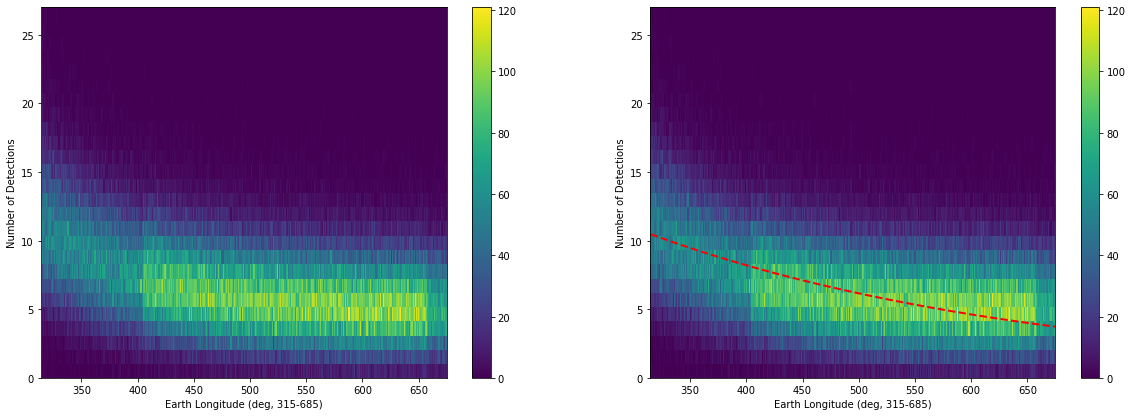

In [10]:
x_ = data[2,0:200000:1]
plt.subplot(2, 2, 1)
plt.hist2d(np.where( x_<315 , 360+x_ , x_ ),data[3,0:200000:1], [360, 26])
plt.xlim(314,675)
plt.title('')
plt.xlabel('Earth Longitude (deg, 315-685)')
plt.ylabel('Number of Detections')
plt.colorbar()
x_ = data[2,0:200000:1]
plt.subplot(2, 2, 2)
(mu, sigma) = expon.fit(data[3,0:200000:1])
y = 9000*expon.pdf(np.linspace(315,675,200000), mu, 50*sigma)
plt.plot(np.linspace(315,675,200000), y, 'r--', linewidth=2)
plt.hist2d(np.where( x_<315 , 360+x_ , x_ ),data[3,0:200000:1], [360, 26])
plt.xlim(314,675)
plt.title('')
plt.xlabel('Earth Longitude (deg, 315-685)')
plt.ylabel('Number of Detections')
plt.colorbar()
plt.show()

3)  The model above isnt perfect, but using a fit line and ajusting for scale, the background looks allot like the exponential PDF graphed over it. 

4) (im not sure whats being asked here?????) "Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?"

-------------------------------

Problem 2

-----------------------------------

 "Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf()."
 
 Plotting the first image and all images stacked ontop of eachother below, we can see that there is definently signal contamination!! lots of bright points that can be seen on all of the images. Looking across all the images the background does not seem to be time dependent in any real way, but the images show spacialy consistent data. To calculate the background pdf we will have to remove the signal contamination and fit a line to the signal-free background. 

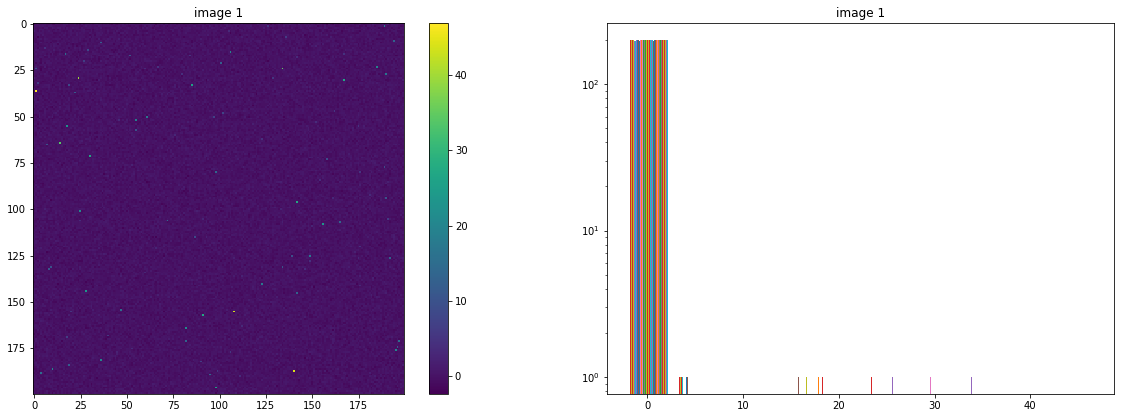

In [18]:
hf.close()
hf_ = h5py.File('images.h5', 'r')
#print(hf_.keys())
plt.subplot(2, 2, 1)
imagestack = hf_['imagestack']
image = hf_['image1']
plt.imshow(image)
plt.colorbar()
plt.title('image 1')
#plt.show()
plt.subplot(2, 2, 2)
plt.hist(image)
plt.yscale('log')
plt.title('image 1')
plt.xlabel('')
plt.ylabel('')
plt.show()

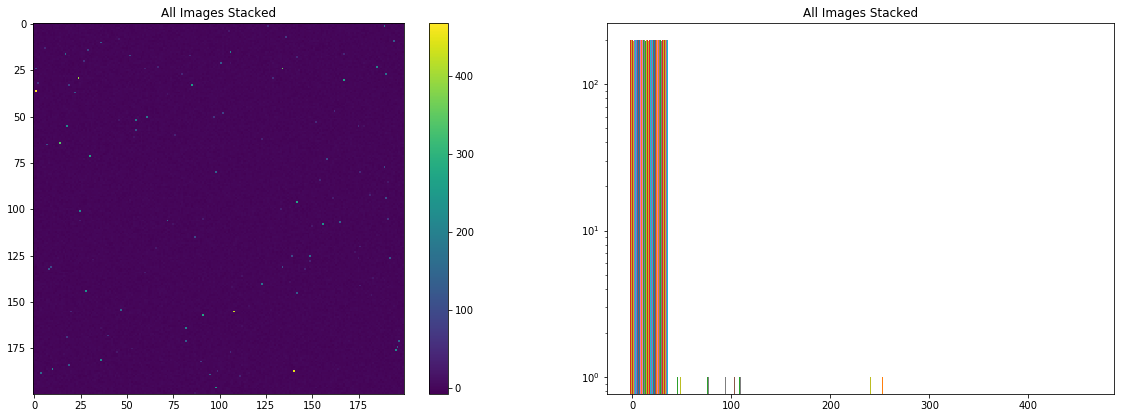

In [19]:
plt.subplot(2, 2, 1)
ff = imagestack[:,:,0]+imagestack[:,:,1]+imagestack[:,:,2]+imagestack[:,:,3]+imagestack[:,:,4]+imagestack[:,:,5]+imagestack[:,:,6]+imagestack[:,:,7]+imagestack[:,:,8]+imagestack[:,:,9]
plt.imshow(ff)
plt.colorbar()
plt.title('All Images Stacked')
#plt.show()
plt.subplot(2, 2, 2)
plt.hist(ff)
plt.yscale('log')
plt.title('All Images Stacked')
plt.xlabel('')
plt.ylabel('')
plt.show()

------------------------------------------------------------------------------------
Below, I am subtracting two of the images to get the signal free background

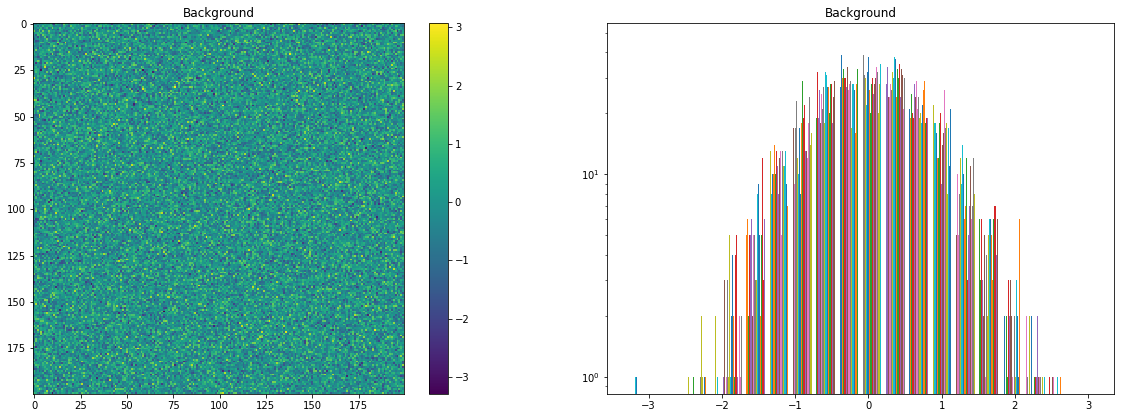

In [20]:
plt.subplot(2, 2, 1)
plt.imshow(image-imagestack[:,:,3])
plt.colorbar()
plt.title('Background')
plt.xlabel('')
plt.ylabel('')
#plt.show()
plt.subplot(2, 2, 2)
plt.hist(image-imagestack[:,:,3],bins = 20)
plt.yscale('log')
plt.title('Background')
plt.xlabel('')
plt.ylabel('')
plt.show()


_________________________________________________
Now I fit a Norm PDF to the background data distribution: 
    
       and use that pdf to get a 5 sigma value for signal detection

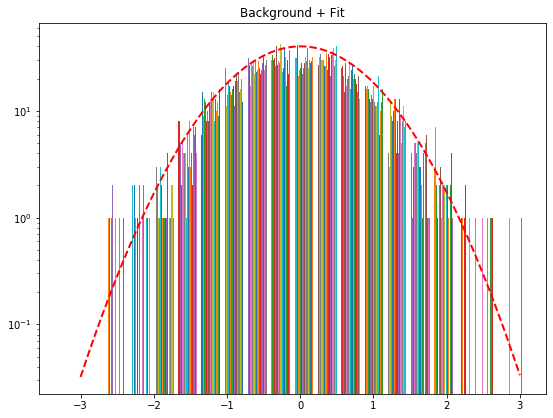

In [24]:
plt.subplot(2, 2, 1)
plt.hist(image-imagestack[:,:,3],bins = 20)
(mu, sigma) = norm.fit((image-imagestack[:,:,3]))
y = (norm.pdf(np.linspace(-3,3,1000), mu, sigma))*80
plt.plot(np.linspace(-3,3,1000), y, 'r--', linewidth=2)
plt.yscale('log')
plt.title('Background + Fit')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [193]:
norm.ppf(norm.cdf(5),mu,sigma) 

3.9828884595856953

_____________________________
According to my background model, any signal above a magnitude of 3.98288 is significant enough to be called a real signal. 

below I remove any data points below the 5 sigma threshold, and produce a image of true stars.

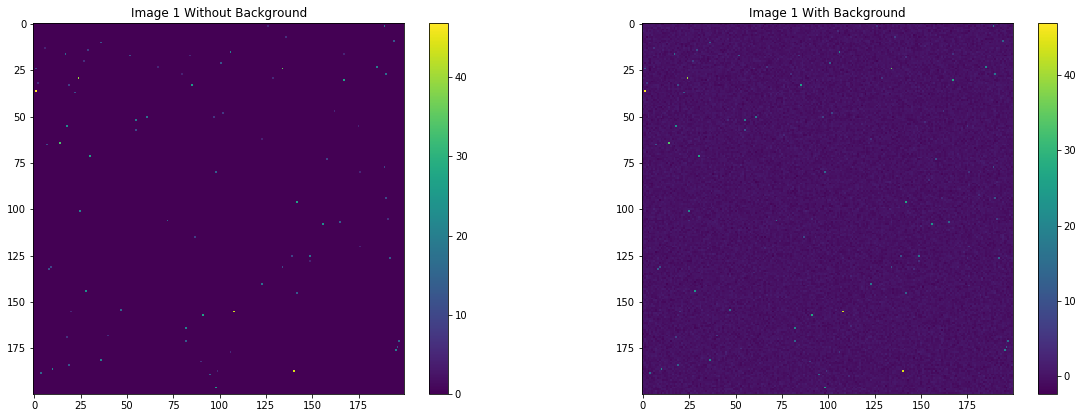

In [21]:
plt.subplot(2, 2, 1)
np.where( image[::]<3.9828884595856953 , 0, image[::] )
plt.imshow(np.where( image[::]<3.9828884595856953 , 0, image[::] ))
#plt.yscale('log')
plt.colorbar()
plt.title('Image 1 Without Background')
plt.xlabel('')
plt.ylabel('')
#plt.show()
plt.subplot(2, 2, 2)
plt.imshow(image)
plt.colorbar()
plt.title('Image 1 With Background')
plt.show()

Above, we can see many faint stars that easily blend into the background distribution (as shown on the right)

4) "You and your lab partner had different pdf(), but were using the same data. Explore why this is."

In this case, almost everyone would generate a slightly different PDF. This could be becuase they found the background with a slightly different method, or the fit the pdf to the background slightly differently. This could effect what is considered a signal in the end, but mostly just for signals that are very "background-like"